In [1]:
from src.data import create_dataset, make_DataLoader, data_visualization

from src.model import Scene_Graph_Model

from src.utils import train_model, test_model, count_parameters, plot_loss, print_relationships

import torch as th

/orfeo/cephfs/home/dssc/stumino/deep_learning/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


# Data Generation

`NUM_IMAGES` images of simple geometric shapes (rectangles, circles and triangles) are going to be generated using matplotlib.

A random number of shapes (maximum in `MAX_OBJECTS`) will be placed on a `IMAGE_SIZE`x`IMAGE_SIZE` image with a white background, with random colors and positions.

The images and the corresponding annotations (class labels and bounding boxes) will be th.saved.

## Image generation

In [2]:
#Constants
TRAIN_IMAGE_DIR = 'train_images'
TEST_IMAGE_DIR = 'test_images'
DATA_DIR = 'data'
TRAIN_ANNOTATIONS = 'train_data.tensor'
TEST_ANNOTATIONS = 'test_data.tensor'
IMAGE_SIZE = 128
SHAPE_SIZE_MIN = 10
SHAPE_SIZE_MAX = 35
NUM_TRAIN_IMAGES = 10000
NUM_TEST_IMAGES = 2000
MAX_OBJECTS = 4

In [3]:
# Generate images
train_data, train_relationships = create_dataset(NUM_TRAIN_IMAGES, IMAGE_SIZE, "ciao", MAX_OBJECTS, SHAPE_SIZE_MIN, SHAPE_SIZE_MAX, geometric=False, rotate=True, origami=True)

# save annotations
th.save(train_data, DATA_DIR + '/' + TRAIN_ANNOTATIONS)
th.save(train_relationships, DATA_DIR + '/train_relationships.tensor')

The directory ciao already exists. Do you want to delete it? [y/n]


 y


Creating image dataset, size: 19.14 MB: 100%|████████████████████████████████████| 10000/10000 [06:49<00:00, 24.44it/s]


In [4]:
# Generate images
test_data, test_relationships = create_dataset(NUM_TEST_IMAGES, IMAGE_SIZE, TEST_IMAGE_DIR, MAX_OBJECTS, SHAPE_SIZE_MIN, SHAPE_SIZE_MAX, geometric=False, rotate=False, origami=True)

# save annotations
th.save(test_data, DATA_DIR + '/' + TEST_ANNOTATIONS)
th.save(test_relationships, DATA_DIR + "/test_relationships.tensor")

Creating image dataset, size: 4.46 MB: 100%|███████████████████████████████████████| 2000/2000 [01:19<00:00, 25.13it/s]


## Display Data

### Data Visualization

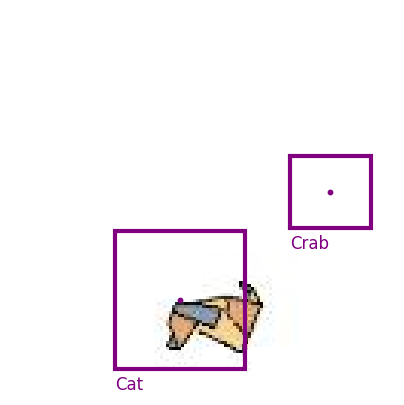

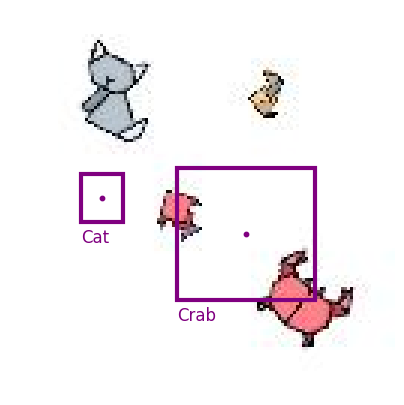

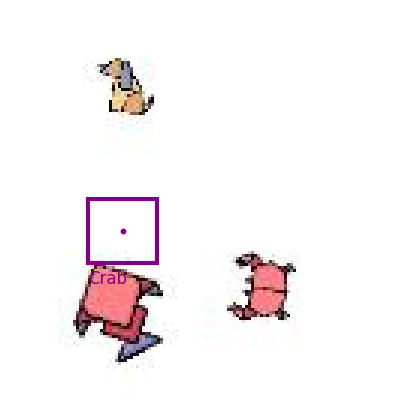

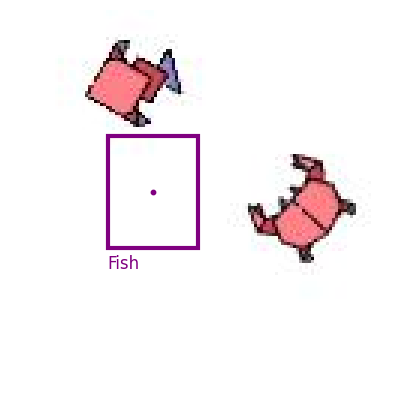

In [7]:
data_visualization(real=True, origami=True)

## DataLoader

### Image loading

In [7]:
make_DataLoader(TRAIN_IMAGE_DIR, TEST_IMAGE_DIR, IMAGE_SIZE, DATA_DIR, TRAIN_ANNOTATIONS, TEST_ANNOTATIONS)

Loading the images in test_images...: 100%|██████████████████████████████████████| 2000/2000 [00:00<00:00, 2618.79it/s]


Loading Complete


# Model

In [8]:
train_loader = th.load('./dataloaders/train_loader.tensor')
test_loader = th.load('./dataloaders/test_loader.tensor')

In [9]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")

# model = Scene_Graph_Model(num_boxes=5, num_classes=3, num_relation=6).to(device)
model = Scene_Graph_Model(num_boxes=4, num_classes=4, num_relation=6).to(device)

# criterion = lambda y_hat, y, relation_out, relation: th.nn.functional.cross_entropy(y_hat[:, 0, :4], y[:, 0, :4]) \
#                             + th.nn.functional.cross_entropy(y_hat[:, 1, :4], y[:, 1, :4]) \
#                             + th.nn.functional.cross_entropy(y_hat[:, 2, :4], y[:, 2, :4]) \
#                             + th.nn.functional.cross_entropy(y_hat[:, 3, :4], y[:, 3, :4]) \
#                             + th.nn.functional.cross_entropy(y_hat[:, 4, :4], y[:, 4, :4]) \
#                             + th.nn.functional.mse_loss(y_hat[:, :, 4:], y[:, :, 4:]) \
#                             + th.nn.functional.binary_cross_entropy_with_logits(relation_out, relation)

criterion = lambda y_hat, y, relation_out, relation: th.nn.functional.cross_entropy(y_hat[:, 0, :5], y[:, 0, :5]) \
                                                   + th.nn.functional.cross_entropy(y_hat[:, 1, :5], y[:, 1, :5]) \
                                                   + th.nn.functional.cross_entropy(y_hat[:, 2, :5], y[:, 2, :5]) \
                                                   + th.nn.functional.cross_entropy(y_hat[:, 3, :5], y[:, 3, :5]) \
                                                   + th.nn.functional.mse_loss(y_hat[:, :, 5:], y[:, :, 5:]) \
                                                   + th.nn.functional.binary_cross_entropy_with_logits(relation_out, relation)

In [61]:


criterion = lambda y_hat, y, relation_out, relation: th.nn.functional.cross_entropy(y_hat[:, 0, :4], y[:, 0, :4]) \
                                                   + th.nn.functional.cross_entropy(y_hat[:, 1, :4], y[:, 1, :4]) \
                                                   + th.nn.functional.cross_entropy(y_hat[:, 2, :4], y[:, 2, :4]) \
                                                   + th.nn.functional.cross_entropy(y_hat[:, 3, :4], y[:, 3, :4]) \
                                                   + th.nn.functional.cross_entropy(y_hat[:, 4, :4], y[:, 4, :4]) \
                                                   + th.nn.functional.mse_loss(y_hat[:, :, 4:], y[:, :, 4:]) \
                                                   + th.nn.functional.binary_cross_entropy_with_logits(relation_out, relation)

In [14]:
optimizer = th.optim.Adam(model.parameters(), lr=1e-4)
model, train_loss, test_loss = train_model(model, optimizer, criterion, train_loader, test_loader, 20)

Loss 6.5890/14.9376, Acc 0.93/0.92, Relation: 0.96/0.93: 100%|█████████████████████████| 20/20 [01:19<00:00,  3.98s/it]


In [6]:
count_parameters(model)

+-------------------------------+------------+
|            Modules            | Parameters |
+-------------------------------+------------+
|       block1.0.0.weight       |    432     |
|        block1.0.0.bias        |     16     |
|       block1.0.1.weight       |     16     |
|        block1.0.1.bias        |     16     |
|       block1.1.0.weight       |    4608    |
|        block1.1.0.bias        |     32     |
|       block1.1.1.weight       |     32     |
|        block1.1.1.bias        |     32     |
|       block1.2.0.weight       |   18432    |
|        block1.2.0.bias        |     64     |
|       block1.2.1.weight       |     64     |
|        block1.2.1.bias        |     64     |
|       block1.3.0.weight       |   73728    |
|        block1.3.0.bias        |    128     |
|       block1.3.1.weight       |    128     |
|        block1.3.1.bias        |    128     |
|       block1.4.0.weight       |   32768    |
|        block1.4.0.bias        |    256     |
|       block

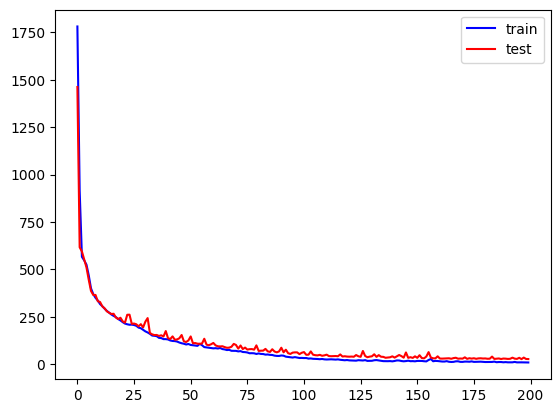

In [7]:
plot_loss(train_loss, test_loss)

In [19]:
# save the model
# os.makedirs('./models', exist_ok=True)
th.save(model.state_dict(), './models/best_origami_model.pth')

In [12]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model = Scene_Graph_Model(num_boxes=4, num_classes=4, num_relation=6).to(device)
# model = Scene_Graph_Model(num_boxes=5, num_classes=3, num_relation=6).to(device)
# weights = th.load('./models/best_geometric_model.pth')
weights = th.load('./models/best_origami_model.pth')
# weights = th.load('./models/best_realimage_model.pth')
model.load_state_dict(weights)

<All keys matched successfully>

Creating image dataset, size: 0.00 MB: 100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.62it/s]
Traceback (most recent call last):
  File "/orfeo/cephfs/home/dssc/stumino/deep_learning/lib64/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2527197/727563736.py", line 1, in <module>
    test_image_data, relation, out, out_relation = test_model(model, device, DATA_DIR, geometric=False, rotate=True, origami=True)
  File "/orfeo/cephfs/home/dssc/stumino/deep_learning/deep_learning/utils.py", line 344, in test_model
  File "/orfeo/cephfs/home/dssc/stumino/deep_learning/lib64/python3.9/site-packages/networkx/classes/digraph.py", line 703, in add_edge
    raise ValueError("None cannot be a node")
ValueError: None cannot be a node

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/orfeo/cephfs/home/d

tensor([[[[False,  True,  True, False],
          [False, False,  True, False],
          [False, False, False, False],
          [False,  True,  True, False]],

         [[False, False, False, False],
          [ True, False, False,  True],
          [ True,  True, False,  True],
          [False, False, False, False]],

         [[False,  True,  True,  True],
          [False, False, False, False],
          [False,  True, False,  True],
          [False, False, False, False]],

         [[False, False, False, False],
          [ True, False,  True, False],
          [ True, False, False, False],
          [ True, False,  True, False]],

         [[False, False, False, False],
          [ True, False, False, False],
          [ True,  True, False,  True],
          [ True, False, False, False]],

         [[False,  True,  True,  True],
          [False, False,  True, False],
          [False, False, False, False],
          [False,  True,  True, False]]]], device='cuda:0')
tensor([[[

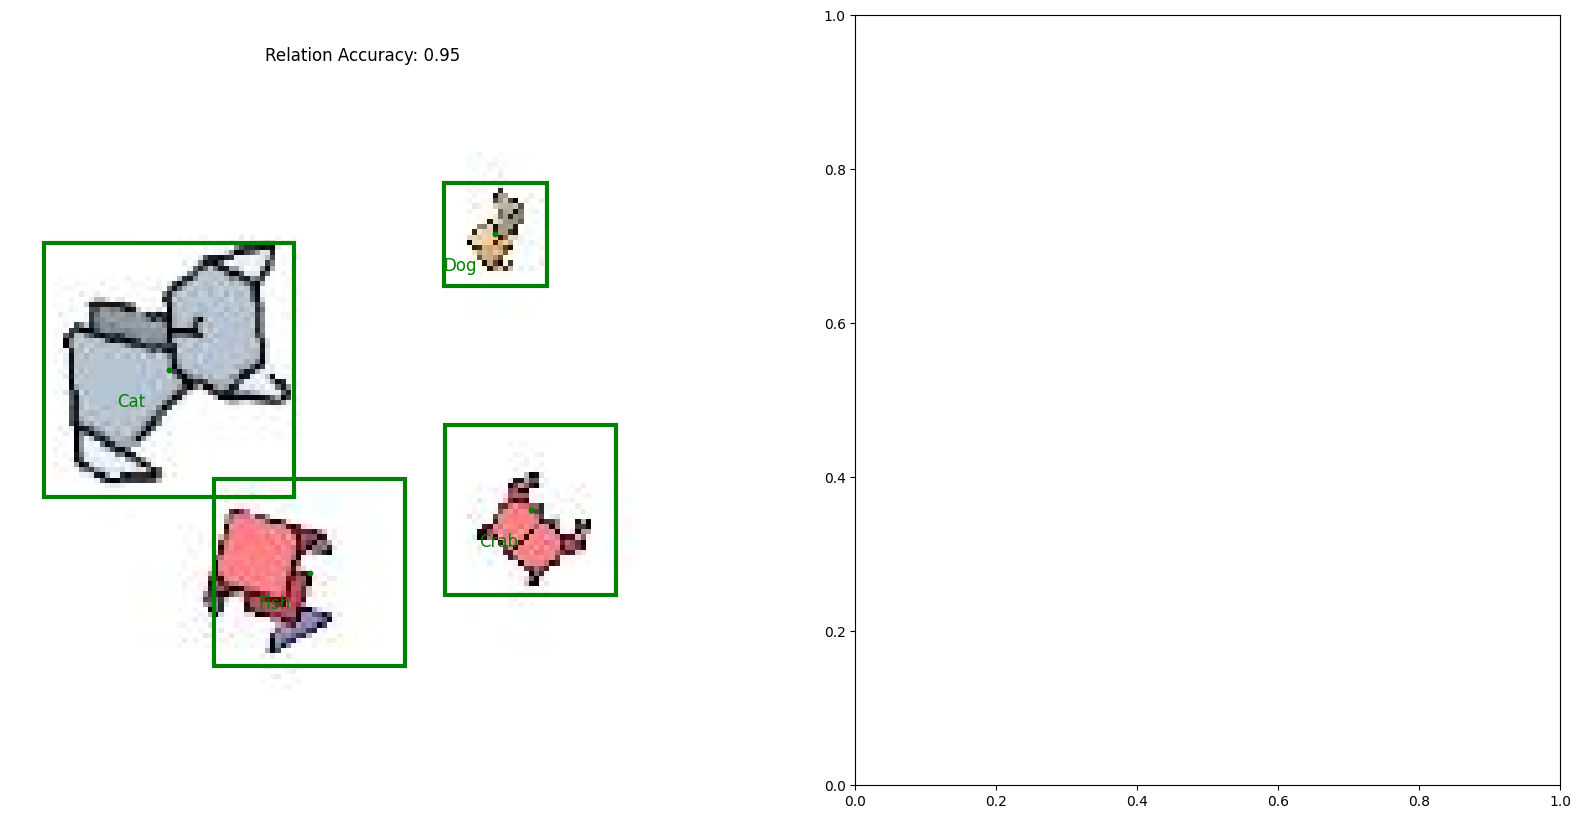

In [18]:
test_image_data, relation, out, out_relation = test_model(model, device, DATA_DIR, geometric=False, rotate=True, origami=True)

In [24]:
print_relationships((th.sigmoid(out_relation[0]) > 0.5).int(), out)

NameError: name 'out_relation' is not defined

In [ ]:
print_relationships(relation[0], out)